In [71]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt

print(torch.__version__)

1.13.0+cu117


In [72]:
input_data = pd.read_csv('radio_train/input_data.csv', header=None)
target_data = pd.read_csv('radio_train/target_data.csv', header=None)

## Data preparation

In [73]:
input_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.325311,0.355525,0.397343,0.284162,0.408696,0.853002,0.481582,0.365663,0.624396,0.630032,0.277494,0.135749,0.222464,0.361413,0.302174,0.125000
1,0.322621,0.348229,0.426276,0.285427,0.404809,0.853958,0.480490,0.371696,0.617918,0.633816,0.280904,0.128623,0.246894,0.367754,0.316667,0.098551
2,0.323370,0.346121,0.439242,0.280596,0.405495,0.853002,0.486542,0.363872,0.619163,0.627599,0.288647,0.135393,0.229469,0.358696,0.306612,0.102355
3,0.324827,0.342754,0.432174,0.276641,0.405217,0.853002,0.482163,0.361514,0.614332,0.630120,0.285507,0.131550,0.230490,0.365942,0.317391,0.111111
4,0.325362,0.347497,0.439538,0.283126,0.416476,0.852484,0.486473,0.361660,0.616667,0.628909,0.288768,0.127415,0.240777,0.362319,0.304865,0.112319


In [74]:
target_data = target_data[[0, 1]]
target_data.head()

,0,1
0,0.156728,-0.070469
1,0.156728,-0.070469
2,0.156728,-0.070469
3,0.156728,-0.070469
4,0.156728,-0.070469


In [75]:
input_train, input_test, target_train, target_test = train_test_split(
    input_data, target_data, test_size=0.2, random_state=42
)

In [76]:
# data for k-fold cross validation
X = torch.from_numpy(input_data.values).float()
y = torch.from_numpy(target_data.values).float()

dataset = TensorDataset(X, y)

In [77]:
# Converting pandas df to torch.Tensor
X_train = torch.from_numpy(input_train.values).float()
X_test = torch.from_numpy(input_test.values).float()
y_train = torch.from_numpy(target_train.values).float()
y_test = torch.from_numpy(target_test.values).float()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1728, 16]),
 torch.Size([1728, 2]),
 torch.Size([432, 16]),
 torch.Size([432, 2]))

In [93]:
BATCH_SIZE = 256
# Creating dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Creating dataloader
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [113]:
class NeuralNet(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.linear_layers_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, 
                out_features=hidden_units,),
            nn.PReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layers_stack(x)


torch.manual_seed(33)
model = NeuralNet(
    input_features=16,
    hidden_units=64,
    output_features=2,
).to(device)

In [114]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

EPOCH: 0
Train loss: 0.00892 | Test loss: 0.00808. | Lowest loss: 0.00782

EPOCH: 1
Train loss: 0.00877 | Test loss: 0.00833. | Lowest loss: 0.00767

EPOCH: 2
Train loss: 0.00859 | Test loss: 0.00787. | Lowest loss: 0.00764

EPOCH: 3
Train loss: 0.00828 | Test loss: 0.00788. | Lowest loss: 0.00746

EPOCH: 4
Train loss: 0.00810 | Test loss: 0.00612. | Lowest loss: 0.00612

EPOCH: 5
Train loss: 0.00746 | Test loss: 0.00823. | Lowest loss: 0.00612

EPOCH: 6
Train loss: 0.00711 | Test loss: 0.00704. | Lowest loss: 0.00612

EPOCH: 7
Train loss: 0.00672 | Test loss: 0.00609. | Lowest loss: 0.00586

EPOCH: 8
Train loss: 0.00619 | Test loss: 0.00644. | Lowest loss: 0.00586

EPOCH: 9
Train loss: 0.00573 | Test loss: 0.00619. | Lowest loss: 0.00514

EPOCH: 10
Train loss: 0.00538 | Test loss: 0.00519. | Lowest loss: 0.00480

EPOCH: 11
Train loss: 0.00499 | Test loss: 0.00503. | Lowest loss: 0.00460

EPOCH: 12
Train loss: 0.00465 | Test loss: 0.00500. | Lowest loss: 0.00413

EPOCH: 13
Train loss: 

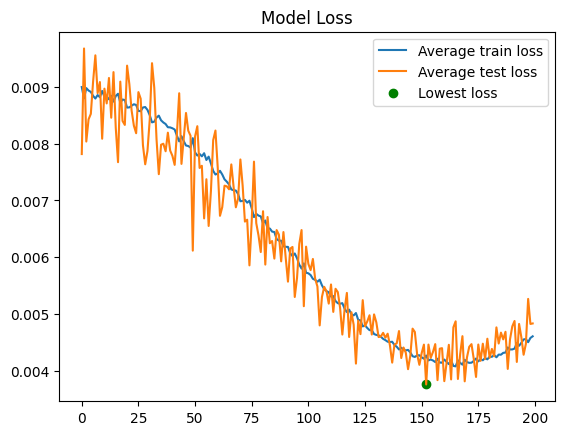

In [115]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True)
train_hist, test_hist = [], []

num_epochs = 20
lowest_loss = float('+inf')
best_state_dict = None
for epoch in range(num_epochs):
    for n, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
        train_dl = DataLoader(TensorDataset(*dataset[train_idx]), batch_size=BATCH_SIZE)
        test_dl = DataLoader(TensorDataset(*dataset[test_idx]), batch_size=BATCH_SIZE)

        # training pass
        train_loss = 0
        for (X, y) in train_dl:
            model.train()
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad
            loss.backward()
            optimizer.step()
        

        train_loss /= len(train_dl)

        test_loss = 0 
        model.eval()
        with torch.inference_mode():
            for (X, y) in test_dl:
                test_pred = model(X)
                test_loss += loss_fn(test_pred, y)

            test_loss /= len(test_dl)
        
            train_hist.append(float(train_loss))
            test_hist.append(float(test_loss))
        if test_loss < lowest_loss:
            lowest_loss = test_loss
            best_state_dict = model.state_dict()

    print(f'EPOCH: {epoch}')
    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}. | Lowest loss: {lowest_loss:.5f}\n")

plt.plot(train_hist, label='Average train loss')
plt.plot(test_hist, label='Average test loss')
plt.scatter(x=test_hist.index(lowest_loss), y=lowest_loss, c='green', label='Lowest loss')
plt.title('Model Loss')
plt.legend()

In [83]:
model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [84]:
torch.save(model, 'moded_radion_NN.pth')